# **DQN 기반 실험**
- Target Network가 고정되어 있으면 왜 안정적인가? 에 대한 실험 <br>
- DQN, Double DQN, Dueling DQN, DRQN 중 어떤 모델이 갑작스러운 환경 변화에 대처를 잘할까? 에 대한 실험

In [2]:
# 필요 라이브러리 로드
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
import warnings
import gym
from gym.wrappers import FrameStack
import gymnasium as gym  # gymnasium만 사용
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2

warnings.filterwarnings("ignore", category=DeprecationWarning)
# 지저분한 deprecation warning 문구 제거

device = "cuda" if torch.cuda.is_available() else "cpu"

## **[1] DQN-Target Network's fixed mode experiment - env:Atari** 

In [4]:
# ✅ 환경 설정
config = {
    "env_name": "Acrobot-v1",
    "batch": 64,
    "buffer_size": 10000,
    "lr": 0.001,
    "gamma": 0.99,
    "epsilon_init": 1.0,
    "epsilon_min": 0.01,
    "epsilon_decay": 0.995,
    "n_step": 50000,
    "n_train_start": 1000,
    "target_update_freq": 100,
    "test_freq": 1000,
}

# ✅ CUDA 설정
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

# ✅ 환경 초기화
env = gym.make(config["env_name"], render_mode="rgb_array")
test_env = gym.make(config["env_name"], render_mode="rgb_array")
dState = env.observation_space.shape[0]
dAction = env.action_space.n


# ✅ Q-Network 정의
class QNetwork(nn.Module):
    def __init__(self, dState, dAction):
        super(QNetwork, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(dState, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, dAction),
        )

    def forward(self, x):
        return self.layers(x)


# ✅ Epsilon-Greedy 탐색
def getAction(state, dAction, epsilon, Q):
    if random.random() < epsilon:
        return random.randint(0, dAction - 1)
    else:
        state = torch.tensor(state, dtype=torch.float32, device=DEVICE).unsqueeze(0)
        return Q(state).argmax(dim=-1).item()

Using device: cuda


In [13]:
# ✅ DQN 클래스
class DQN:
    def __init__(self, env, test_env, Qnet, config, device):
        self.env = env
        self.test_env = test_env
        self.device = device

        self.dState = env.observation_space.shape[0]
        self.dAction = env.action_space.n

        self.Q = Qnet(dState=self.dState, dAction=self.dAction).to(device)
        self.targetQ = Qnet(dState=self.dState, dAction=self.dAction).to(device)
        self.targetQ.load_state_dict(self.Q.state_dict())

        self.optimizerQ = optim.Adam(self.Q.parameters(), lr=config["lr"])
        self.replay_buffer = deque(maxlen=config["buffer_size"])

        self.gamma = config["gamma"]
        self.epsilon = config["epsilon_init"]

        self.score = 0.0
        self.scores = []
        self.test_scores = []
        self.losses = []
        self.qs = []

    def experience_before_train(self):
        """ 학습 전 리플레이 버퍼 채우기 """
        obs, _ = self.env.reset()
        state = np.array(obs, dtype=np.float32)

        for _ in range(config["n_train_start"]):
            action = getAction(state, self.dAction, self.epsilon, self.Q)
            next_obs, reward, done, _, _ = self.env.step(action)
            next_state = np.array(next_obs, dtype=np.float32)

            self.replay_buffer.append((state, action, reward, next_state, done))
            state = next_state

            if done:
                obs, _ = self.env.reset()
                state = np.array(obs, dtype=np.float32)

    def train(self):
        """ DQN 학습 루프 """
        obs, _ = self.env.reset()
        state = np.array(obs, dtype=np.float32)

        for t in tqdm(range(1, config["n_step"] + 1)):
            action = getAction(state, self.dAction, self.epsilon, self.Q)
            next_obs, reward, done, truncated, _ = self.env.step(action)
            next_state = np.array(next_obs, dtype=np.float32)

            self.replay_buffer.append((state, action, reward, next_state, done))
            self.score += reward
            state = next_state

            if done or truncated:  # 수정된 종료 조건
                obs, _ = self.env.reset()
                state = np.array(obs, dtype=np.float32)
                self.scores.append(self.score)
                self.score = 0.0
                self.epsilon = max(config["epsilon_min"], self.epsilon * config["epsilon_decay"])

            if len(self.replay_buffer) >= config["batch"]:
                transitions = random.sample(self.replay_buffer, config["batch"])
                batch = [torch.tensor(np.array(x), dtype=torch.float32, device=self.device) for x in zip(*transitions)]
                states, actions, rewards, nextStates, dones = batch

                actions = actions.long().unsqueeze(dim=-1)
                rewards = rewards.unsqueeze(dim=-1)
                dones = dones.unsqueeze(dim=-1)

                estimateQs = self.Q(states).gather(dim=1, index=actions)

                with torch.no_grad():
                    nextTargetQs = self.targetQ(nextStates).max(dim=-1, keepdim=True).values
                    targetQs = rewards + (1 - dones) * self.gamma * nextTargetQs

                loss = F.mse_loss(targetQs.detach(), estimateQs)

                self.optimizerQ.zero_grad()
                loss.backward()
                self.optimizerQ.step()

                self.losses.append(loss.detach().cpu().item())
                self.qs.append(estimateQs.detach().mean().cpu().item())

            if t % config["target_update_freq"] == 0:
                self.targetQ.load_state_dict(self.Q.state_dict())

            if t % config["test_freq"] == 0:
                test_score = test(self.test_env, self.Q, self.dAction, epsilon=config["epsilon_min"])
                self.test_scores.append(test_score)

        return test_score


# ✅ 환경 테스트 함수
def test(env, Q, dAction, epsilon):
    obs, _ = env.reset()
    state = np.array(obs, dtype=np.float32)
    score = 0.0
    done = False

    while not done:
        action = getAction(state, dAction, epsilon, Q)
        next_obs, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated  # 두 조건 중 하나라도 참이면 에피소드 종료
        state = np.array(next_obs, dtype=np.float32)
        score += reward

    return score


import matplotlib.animation as animation


import matplotlib.animation as animation

def render_simulation(env, agent, num_episodes=1, save_path=None):
    """
    학습된 DQN 에이전트가 Acrobot 환경에서 동작하는 모습을 애니메이션으로 보여주는 함수.
    
    Args:
        env: Gym 환경 (`render_mode="rgb_array"`로 설정되어 있어야 함)
        agent: 학습된 DQN 에이전트
        num_episodes: 실행할 에피소드 수
        save_path: GIF로 저장할 경로 (예: "simulation.gif"), None이면 저장 안 함
    """
    frames = []

    for episode in range(num_episodes):
        obs, _ = env.reset()
        state = np.array(obs, dtype=np.float32)
        done = False

        while not done:
            frame = env.render()  # ✅ 현재 환경 프레임 캡처
            
            if frame is None:  # ✅ 렌더링이 실패한 경우 예외 처리
                print("Warning: env.render() returned None. Skipping frame.")
                continue
            
            frame = np.array(frame, dtype=np.uint8)  # ✅ NumPy 배열로 변환 (오류 방지)
            frames.append(frame)

            action = agent(state)  # ✅ 에이전트가 행동 선택
            next_obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated  # 두 조건 중 하나라도 참이면 에피소드 종료
            state = np.array(next_obs, dtype=np.float32)
            
    env.close()

    if len(frames) == 0:
        print("Error: No frames captured. Ensure the environment is correctly set up with render_mode='rgb_array'.")
        return  # ✅ 프레임이 없으면 실행 중지

    # ✅ 애니메이션 생성
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.axis("off")
    img = ax.imshow(frames[0])  # 첫 번째 프레임 설정

    def update(frame_idx):
        img.set_array(frames[frame_idx])  # 새로운 프레임으로 업데이트

    ani = animation.FuncAnimation(fig, update, frames=len(frames), interval=50)

    # ✅ 애니메이션 저장 (옵션)
    if save_path:
        ani.save(save_path, writer="pillow")  # ✅ GIF로 저장

    plt.show()


In [14]:
# ✅ DQN 학습 실행
target_fixed_dqn = DQN(env, test_env, QNetwork, config, DEVICE)
target_fixed_dqn.experience_before_train()  # 학습 전 리플레이 버퍼 채우기
target_fixed_test_score = target_fixed_dqn.train()
# ✅ 학습된 모델 시뮬레이션 시각화 (GIF 저장 가능)
render_simulation(env, lambda s: getAction(s, dAction, epsilon=0.01, Q=target_fixed_dqn.Q), save_path="simulation_fixed.gif")

# ✅ 학습 결과 그래프 출력
plt.plot(target_fixed_dqn.scores, label="Training Score")
plt.plot(target_fixed_dqn.test_scores, label="Test Score")
plt.xlabel("Episodes")
plt.ylabel("Score")
plt.legend()
plt.title("DQN Training on Acrobot-v1")
plt.show()

  2%|█▏                                                       | 2030/100000 [00:04<03:50, 424.23it/s]


KeyboardInterrupt: 

100%|██████████████████████████████████████████████████████████████████████████████| 50000/50000 [02:00<00:00, 415.12it/s]


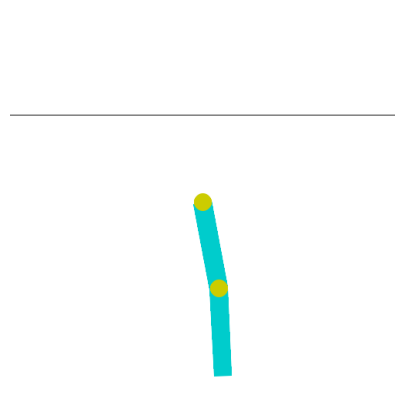

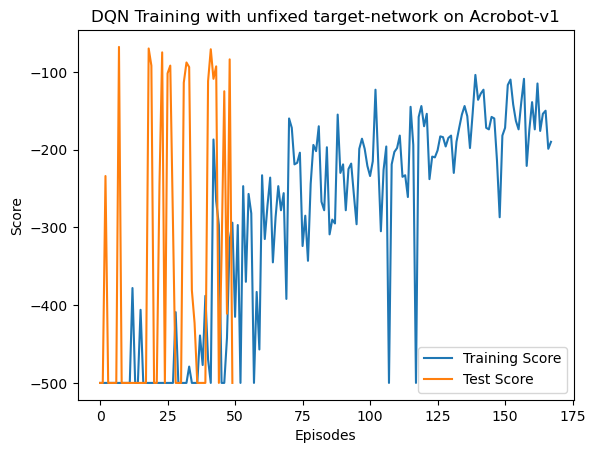

In [5]:
# ✅ DQN 학습 실행
config["target_update_freq"] = 1 

target_unfixed_dqn = DQN(env, test_env, QNetwork, config, DEVICE)
target_unfixed_dqn.experience_before_train()  # 학습 전 리플레이 버퍼 채우기
target_unfixed_test_score = target_unfixed_dqn.train()
# ✅ 학습된 모델 시뮬레이션 시각화 (GIF 저장 가능)
render_simulation(env, lambda s: getAction(s, dAction, epsilon=0.01, Q=target_unfixed_dqn.Q), save_path="simulation_unfixed.gif")

# ✅ 학습 결과 그래프 출력
plt.plot(target_unfixed_dqn.scores, label="Training Score")
plt.plot(target_unfixed_dqn.test_scores, label="Test Score")
plt.xlabel("Episodes")
plt.ylabel("Score")
plt.legend()
plt.title("DQN Training with unfixed target-network on Acrobot-v1")
plt.show()

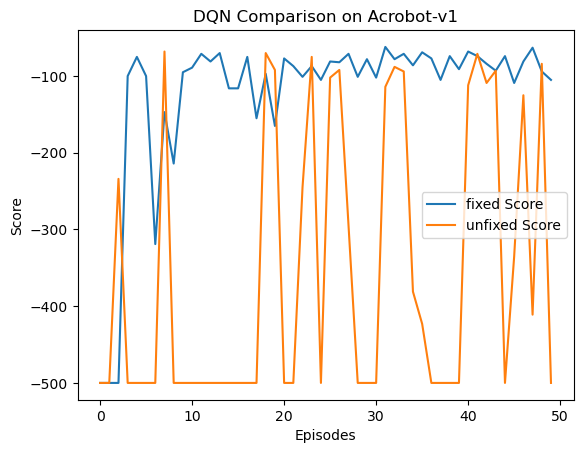

In [6]:
# ✅ 학습 결과 그래프 출력
plt.plot(target_fixed_dqn.test_scores, label="fixed Score")
plt.plot(target_unfixed_dqn.test_scores, label="unfixed Score")
plt.xlabel("Episodes")
plt.ylabel("Score")
plt.legend()
plt.title("DQN Comparison on Acrobot-v1")
plt.show()

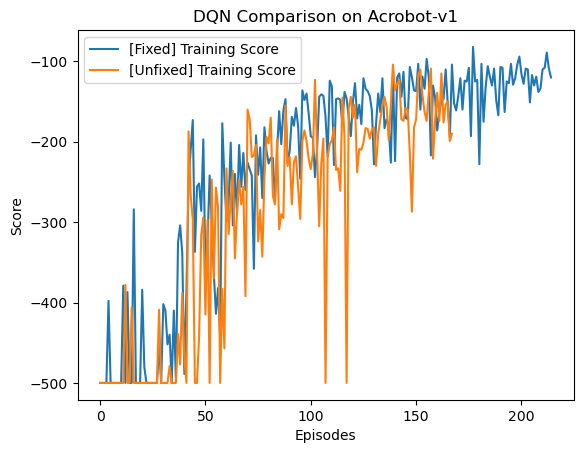

In [7]:
# ✅ 학습 결과 그래프 출력
plt.plot(target_fixed_dqn.scores, label="[Fixed] Training Score")
plt.plot(target_unfixed_dqn.scores, label="[Unfixed] Training Score")
plt.xlabel("Episodes")
plt.ylabel("Score")
plt.legend()
plt.title("DQN Comparison on Acrobot-v1")
plt.show()

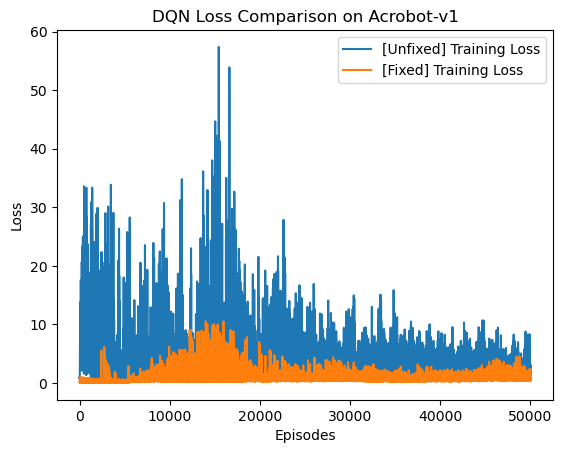

In [8]:
# ✅ 학습 결과 그래프 출력
plt.plot(target_unfixed_dqn.losses, label="[Unfixed] Training Loss")
plt.plot(target_fixed_dqn.losses, label="[Fixed] Training Loss")
plt.xlabel("Episodes")
plt.ylabel("Loss")
plt.legend()
plt.title("DQN Loss Comparison on Acrobot-v1")
plt.show()

100%|██████████████████████████████████████████████████████████████████████████████| 50000/50000 [01:46<00:00, 467.68it/s]


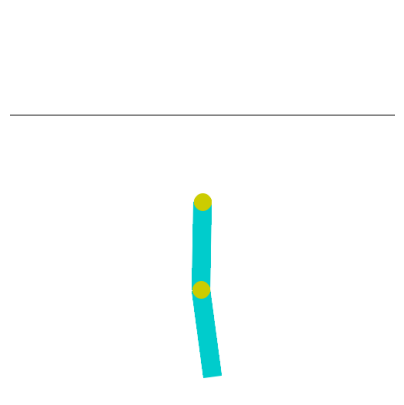

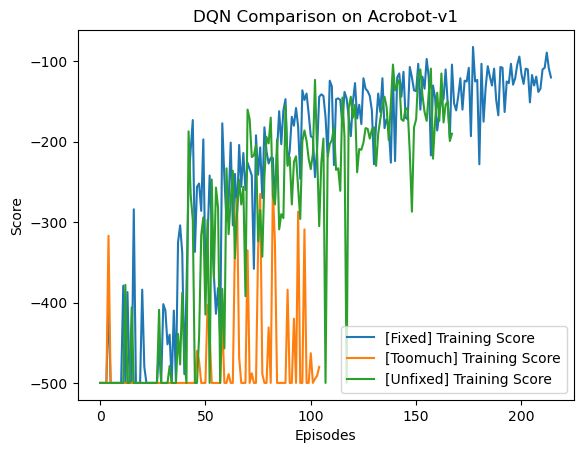

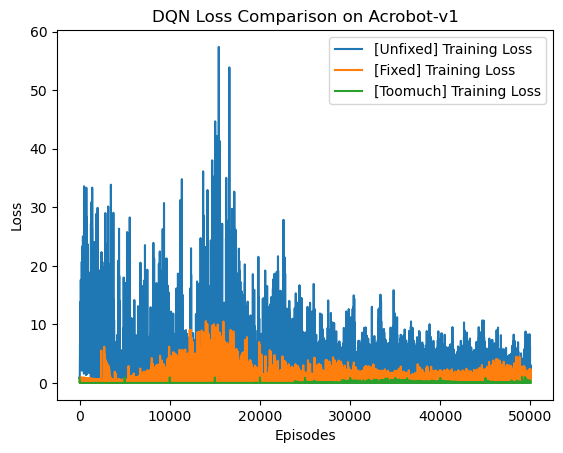

In [9]:
# ✅ DQN 학습 실행
config["target_update_freq"] = 5000

target_toomuch_dqn = DQN(env, test_env, QNetwork, config, DEVICE)
target_toomuch_dqn.experience_before_train()  # 학습 전 리플레이 버퍼 채우기
target_toomuch_test_score = target_toomuch_dqn.train()
# ✅ 학습된 모델 시뮬레이션 시각화 (GIF 저장 가능)
render_simulation(env, lambda s: getAction(s, dAction, epsilon=0.01, Q=target_toomuch_dqn.Q), save_path="simulation_toomuch.gif")

# ✅ 학습 결과 그래프 출력
plt.plot(target_fixed_dqn.scores, label="[Fixed] Training Score")
plt.plot(target_toomuch_dqn.scores, label="[Toomuch] Training Score")
plt.plot(target_unfixed_dqn.scores, label="[Unfixed] Training Score")
plt.xlabel("Episodes")
plt.ylabel("Score")
plt.legend()
plt.title("DQN Comparison on Acrobot-v1")
plt.show()

# ✅ 학습 결과 그래프 출력
plt.plot(target_unfixed_dqn.losses, label="[Unfixed] Training Loss")
plt.plot(target_fixed_dqn.losses, label="[Fixed] Training Loss")
plt.plot(target_toomuch_dqn.losses, label="[Toomuch] Training Loss")
plt.xlabel("Episodes")
plt.ylabel("Loss")
plt.legend()
plt.title("DQN Loss Comparison on Acrobot-v1")
plt.show()

### **[실험 결과 해석]**
(1) Target-Network를 Fix하지 않으면 안정적이지 않다는 textbook 내용 확인 > 실험 진행 <br>
(2) DQN Acrobotic 환경에서 Target-Network의 주기를 각각 1, 100으로 두고 실험 <br>
(3) 결과 1 - done, truncated된 횟수가 fixed 모델에서 더 많았음 <br>
(4) 결과 2 - Test Score도 전반적으로 fixed가 우수한 점수를 얻음 <br>
(5) 결과 3 - Training Loss를 확인해보면, max(Target-Network) - Previous-Network가 loss이기에 당연하게도 fixed가 더 안정적임 <br>
(6) 결과 4 - unfixed 모델은 target-network이 끊임없이 움직이면서 target에 대한 안정도가 매우 떨어짐. 적절한 Target-network 고정이 필요 <br>
(7) 추가 1 - 만약 Target-Network를 너무 많이 고정시켜둔다면? (업데이트 주기를 100 > 5000) -> 학습이 되지 않음 <br>
(8) 추가 2 - 이는 학습에 알맞게 Target-Network도 적절히 업데이트되어야 함에도 업데이트 되지 않아, 성능을 위한 유의미한 학습이 이뤄지지 않은 것으로 보임 

# **[2] Basic DQN, Double DQN, Dueling DQN, DRQN**

In [15]:
def render_simulation(env, agent, num_episodes=1, save_path=None, rnn_true=False):
    """
    학습된 DQN 에이전트가 Acrobot 환경에서 동작하는 모습을 애니메이션으로 보여주는 함수.
    
    Args:
        env: Gym 환경 (`render_mode="rgb_array"`로 설정되어 있어야 함)
        agent: 학습된 DQN 에이전트 (상태를 받아 행동을 반환하는 함수 형태)
        num_episodes: 실행할 에피소드 수
        save_path: GIF로 저장할 경로 (예: "simulation.gif"), None이면 저장 안 함
    """
    frames = []

    for episode in range(num_episodes):
        obs, _ = env.reset()
        state = np.array(obs, dtype=np.float32)
        done = False
        
        if rnn_true:
            h, c = agent.Q.init_state()

        while not done:
            frame = env.render()  # 현재 환경 프레임 캡처
            if frame is None:     # 렌더링 실패 시 예외 처리
                print("Warning: env.render() returned None. Skipping frame.")
                continue
            
            frame = np.array(frame, dtype=np.uint8)  # NumPy 배열로 변환
            frames.append(frame)

            if rnn_true:
                action, h, c = recurrent_getAction(state, h, c, agent.dAction, agent.epsilon, agent.Q)
            else:
                action = getAction(state, agent.dAction, agent.epsilon, agent.Q)
                
            next_obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            state = np.array(next_obs, dtype=np.float32)
            
    env.close()

    if len(frames) == 0:
        print("Error: No frames captured. Ensure the environment is correctly set up with render_mode='rgb_array'.")
        return

    # 애니메이션 생성 (개선된 방식)
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.axis("off")
    im = ax.imshow(frames[0])

    def init():
        im.set_data(frames[0])
        return [im]

    def update(frame_idx):
        im.set_data(frames[frame_idx])
        return [im]

    ani = animation.FuncAnimation(fig, update, frames=range(len(frames)),
                                  init_func=init, interval=50, blit=True)

    # 애니메이션 저장 (옵션)
    if save_path:
        ani.save(save_path, writer="pillow", fps=20)

    plt.show()

In [16]:
# ✅ DQN 클래스
class Basic_DQN:
    def __init__(self, env, test_env, Qnet, config, device):
        self.env = env
        self.test_env = test_env
        self.device = device

        self.dState = env.observation_space.shape[0]
        self.dAction = env.action_space.n

        self.Q = Qnet(dState=self.dState, dAction=self.dAction).to(device)
        self.targetQ = Qnet(dState=self.dState, dAction=self.dAction).to(device)
        self.targetQ.load_state_dict(self.Q.state_dict())

        self.optimizerQ = optim.Adam(self.Q.parameters(), lr=config["lr"])
        self.replay_buffer = deque(maxlen=config["buffer_size"])

        self.gamma = config["gamma"]
        self.epsilon = config["epsilon_init"]

        self.score = 0.0
        self.scores = []
        self.test_scores = []
        self.losses = []
        self.qs = []

    def experience_before_train(self):
        """ 학습 전 리플레이 버퍼 채우기 """
        obs, _ = self.env.reset()
        state = np.array(obs, dtype=np.float32)

        for _ in range(config["n_train_start"]):
            action = getAction(state, self.dAction, self.epsilon, self.Q)
            next_obs, reward, done, _, _ = self.env.step(action)
            next_state = np.array(next_obs, dtype=np.float32)

            self.replay_buffer.append((state, action, reward, next_state, done))
            state = next_state

            if done:
                obs, _ = self.env.reset()
                state = np.array(obs, dtype=np.float32)

    def train(self):
        """ DQN 학습 루프 """
        obs, _ = self.env.reset()
        state = np.array(obs, dtype=np.float32)

        for t in tqdm(range(1, config["n_step"] + 1)):
            action = getAction(state, self.dAction, self.epsilon, self.Q)
            next_obs, reward, done, _, _ = self.env.step(action)
            next_state = np.array(next_obs, dtype=np.float32)

            self.replay_buffer.append((state, action, reward, next_state, done))
            self.score += reward
            state = next_state

            if done:
                obs, _ = self.env.reset()
                state = np.array(obs, dtype=np.float32)
                self.scores.append(self.score)
                self.score = 0.0
                self.epsilon = max(config["epsilon_min"], self.epsilon * config["epsilon_decay"])

            if len(self.replay_buffer) >= config["batch"]:
                transitions = random.sample(self.replay_buffer, config["batch"])
                batch = [torch.tensor(np.array(x), dtype=torch.float32, device=self.device) for x in zip(*transitions)]
                states, actions, rewards, nextStates, dones = batch

                actions = actions.long().unsqueeze(dim=-1)
                rewards = rewards.unsqueeze(dim=-1)
                dones = dones.unsqueeze(dim=-1)

                estimateQs = self.Q(states).gather(dim=1, index=actions)

                with torch.no_grad():
                    nextTargetQs = self.targetQ(nextStates).max(dim=-1, keepdim=True).values
                    targetQs = rewards + (1 - dones) * self.gamma * nextTargetQs

                loss = F.mse_loss(targetQs.detach(), estimateQs)

                self.optimizerQ.zero_grad()
                loss.backward()
                self.optimizerQ.step()

                self.losses.append(loss.detach().cpu().item())
                self.qs.append(estimateQs.detach().mean().cpu().item())

            if t % config["target_update_freq"] == 0:
                self.targetQ.load_state_dict(self.Q.state_dict())

            if t % config["test_freq"] == 0:
                test_score = test(self.test_env, self.Q, self.dAction, epsilon=config["epsilon_min"])
                self.test_scores.append(test_score)

        return test_score

In [17]:
# ✅ Double DQN 클래스
class Double_DQN:
    def __init__(self, env, test_env, Qnet, config, device):
        self.env = env
        self.test_env = test_env
        self.device = device

        self.dState = env.observation_space.shape[0]
        self.dAction = env.action_space.n

        self.Q = Qnet(dState=self.dState, dAction=self.dAction).to(device)
        self.targetQ = Qnet(dState=self.dState, dAction=self.dAction).to(device)
        self.targetQ.load_state_dict(self.Q.state_dict())

        self.optimizerQ = optim.Adam(self.Q.parameters(), lr=config["lr"])
        self.replay_buffer = deque(maxlen=config["buffer_size"])

        self.gamma = config["gamma"]
        self.epsilon = config["epsilon_init"]

        self.score = 0.0
        self.scores = []
        self.test_scores = []
        self.losses = []
        self.qs = []

    def experience_before_train(self):
        """ 학습 전 리플레이 버퍼 채우기 """
        obs, _ = self.env.reset()
        state = np.array(obs, dtype=np.float32)

        for _ in range(config["n_train_start"]):
            action = getAction(state, self.dAction, self.epsilon, self.Q)
            next_obs, reward, done, _, _ = self.env.step(action)
            next_state = np.array(next_obs, dtype=np.float32)

            self.replay_buffer.append((state, action, reward, next_state, done))
            state = next_state

            if done:
                obs, _ = self.env.reset()
                state = np.array(obs, dtype=np.float32)

    def train(self):
        """ DQN 학습 루프 """
        obs, _ = self.env.reset()
        state = np.array(obs, dtype=np.float32)

        for t in tqdm(range(1, config["n_step"] + 1)):
            # state에서 action을 수행
            action = getAction(state, self.dAction, self.epsilon, self.Q)
            # action에 따른 다음 state, reward, done 여부를 리턴
            next_obs, reward, done, _, _ = self.env.step(action)
            # next state를 알맞은 형태로 변형
            next_state = np.array(next_obs, dtype=np.float32)

            self.replay_buffer.append((state, action, reward, next_state, done))
            self.score += reward
            state = next_state

            if done:
                obs, _ = self.env.reset()
                state = np.array(obs, dtype=np.float32)
                self.scores.append(self.score)
                self.score = 0.0
                self.epsilon = max(config["epsilon_min"], self.epsilon * config["epsilon_decay"])

            if len(self.replay_buffer) >= config["batch"]:
                transitions = random.sample(self.replay_buffer, config["batch"])
                batch = [torch.tensor(np.array(x), dtype=torch.float32, device=self.device) for x in zip(*transitions)]
                states, actions, rewards, nextStates, dones = batch

                actions = actions.long().unsqueeze(dim=-1)
                rewards = rewards.unsqueeze(dim=-1)
                dones = dones.unsqueeze(dim=-1)

                estimateQs = self.Q(states).gather(dim=1, index=actions)

                # Double DQN이 여기서 다름을 보임
                with torch.no_grad():
                    # TD error를 구할 때, 본래는 Target-Network의 Q 값은 TargetQ가 수행한 액션으로 평가
                    next_actions = self.Q(nextStates).argmax(dim=1, keepdim=True)
                    # 기존 Q가 선택한 action + state로 평가를 시작
                    nextTargetQs = self.targetQ(nextStates).gather(dim=-1, index=next_actions)
                    targetQs = rewards + (1 - dones) * self.gamma * nextTargetQs

                loss = F.mse_loss(targetQs.detach(), estimateQs)

                self.optimizerQ.zero_grad()
                loss.backward()
                self.optimizerQ.step()

                self.losses.append(loss.detach().cpu().item())
                self.qs.append(estimateQs.detach().mean().cpu().item())

            if t % config["target_update_freq"] == 0:
                self.targetQ.load_state_dict(self.Q.state_dict())

            if t % config["test_freq"] == 0:
                test_score = test(self.test_env, self.Q, self.dAction, epsilon=config["epsilon_min"])
                self.test_scores.append(test_score)

        return test_score

In [18]:
# ✅ Dueling DQN 클래스

# Duel DQN은 Q 네트워크 클래스만 따로 정의
class Duel_Qnet(nn.Module):
    def __init__(self, dState, dAction):
        super().__init__()
        self.featureLayer = nn.Sequential( # 공통 네트워크
            nn.Linear(in_features=dState, out_features=128),
            nn.ReLU(),
        )
        self.valueLayer = nn.Sequential( # value 네트워크
            nn.Linear(in_features=128, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=1),
        )
        self.advantageLayer = nn.Sequential( # advantage 네트워크
            nn.Linear(in_features=128, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=dAction),
        )

    def forward(self, x):     # (dBatch, dState)
        feature = self.featureLayer(x) # (dBatch, dHidden)
        value = self.valueLayer(feature) # (dBatch, 1)
        advantage = self.advantageLayer(feature) # (dBatch, dAction)
        # 공통 네트워크까지 계산된 feature를 각각 분리된 value, advantage 네트워크에 넣어줌
        Q = value + (advantage - advantage.mean(dim=-1, keepdim=True)) # (dBatch, dAction)
        # value와 advantage를 사용하여 Q 계산
        return Q # (dBatch, dAction)

In [19]:
# DQRN (recurrent neural network 활용)
# =============================================================================
# 1. RNN 기반 Q 네트워크 정의
# =============================================================================
class RNNQnet(nn.Module):
    def __init__(self, dState, dAction):
        """
        dState: 상태 공간의 차원 (예: 환경 observation space의 크기)
        dAction: 행동의 개수 (예: 환경 action space의 이산적 개수)
        """
        super(RNNQnet, self).__init__()
        self.dHidden = 128  # 은닉층의 크기; 필요에 따라 조정 가능
        
        # 입력층: 상태를 은닉층 차원으로 매핑
        self.inputLayer = nn.Linear(in_features=dState, out_features=self.dHidden)
        
        # LSTM 층: 시퀀스 데이터를 처리 (batch_first=True)
        self.lstm = nn.LSTM(input_size=self.dHidden, hidden_size=self.dHidden, batch_first=True)
        
        # 출력층: LSTM의 출력을 받아 각 행동에 대한 Q값 산출
        self.outputLayer = nn.Linear(in_features=self.dHidden, out_features=dAction)
        
    def init_state(self, batch_size=1):
        """
        LSTM의 초기 hidden state와 cell state를 0으로 초기화하여 반환합니다.
        """
        h = torch.zeros(1, batch_size, self.dHidden).to(DEVICE)
        c = torch.zeros(1, batch_size, self.dHidden).to(DEVICE)
        return h, c

    def forward(self, x, h, c):
        """
        x: 입력 상태, shape: (batch_size, seq_length, dState)
        h, c: LSTM의 hidden state와 cell state
        반환: Q값 예측, 새로운 hidden state, 새로운 cell state
        """
        # 입력층: 상태를 은닉층 차원으로 매핑 후 ReLU 활성화 적용
        x = F.relu(self.inputLayer(x))  # 결과: (batch, seq, dHidden)
        
        # LSTM 층: 시퀀스 데이터 처리
        x, (h, c) = self.lstm(x, (h, c))  # 결과: (batch, seq, dHidden)
        
        # 출력층: 각 행동에 대한 Q값 출력
        x = self.outputLayer(x)           # 결과: (batch, seq, dAction)
        
        return x, h, c

# =============================================================================
# 2. 행동 선택 및 테스트 함수 (Recurrent Version)
# =============================================================================
def recurrent_getAction(state, h, c, dAction, epsilon, Q):
    """
    주어진 상태(state)와 현재 hidden state (h, c)를 이용하여 Q 네트워크에서 행동을 선택합니다.
    state: numpy array, shape (dState,)
    반환: action, 새로운 hidden state (h, c)
    """
    # state를 텐서로 변환: (1, 1, dState)
    state_tensor = torch.tensor(state, dtype=torch.float32, device=DEVICE).view(1, 1, -1)
    q_values, new_h, new_c = Q(state_tensor, h, c)  # q_values: (1, 1, dAction)
    if random.random() > epsilon:
        action = q_values.argmax(dim=-1).item()
    else:
        action = np.random.randint(low=0, high=dAction)
    return action, new_h, new_c

def test_agent(env, Q, dAction, epsilon=0.0):
    """
    테스트 환경에서 에이전트를 평가하여 한 에피소드 동안의 점수를 반환합니다.
    """
    with torch.no_grad():
        score = 0.0
        state, _ = env.reset()
        h, c = Q.init_state()
        done = False
        while not done:
            action, h, c = recurrent_getAction(state, h, c, dAction, epsilon, Q)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            score += reward
            state = next_state
        return score

# =============================================================================
# 3. DQRN 클래스 (오리지널 DQN 업데이트 방식 사용)
# =============================================================================
class DQRN:
    def __init__(self, env, test_env, RNNQnet, config, device):
        self.env = env
        self.test_env = test_env
        self.device = device

        self.dState = env.observation_space.shape[0]
        self.dAction = env.action_space.n

        # Q 네트워크와 Target Q 네트워크 초기화
        self.Q = RNNQnet(self.dState, self.dAction).to(device)
        self.targetQ = RNNQnet(self.dState, self.dAction).to(device)
        self.targetQ.load_state_dict(self.Q.state_dict())

        self.optimizerQ = optim.Adam(self.Q.parameters(), lr=config["lr"])
        self.replay_buffer = deque(maxlen=config["buffer_size"])

        self.gamma = config["gamma"]
        self.epsilon = config["epsilon_init"]

        self.score = 0.0
        self.scores = []
        self.test_scores = []
        self.losses = []
        self.qs = []

    # 예: experience_before_train 함수 내에서
    def experience_before_train(self):
        h, c = self.Q.init_state()
        state, _ = self.env.reset()  # observation만 추출
        for _ in range(config["n_train_start"]):
            action, h, c = recurrent_getAction(state, h, c, self.dAction, self.epsilon, self.Q)
            next_state, reward, done, _, _ = self.env.step(action)
            self.replay_buffer.append((state, action, reward, next_state, done))
            state = next_state
            if done:
                state, _ = self.env.reset()  # 여기도 observation만 추출
                h, c = self.Q.init_state()

    
    def train(self):
        """오리지널 DQN 업데이트를 사용하는 학습 루프"""
        h, c = self.Q.init_state()
        state, _ = self.env.reset()
        for t in tqdm(range(1, config["n_step"] + 1)):
            # 환경과 상호작용하며 행동 선택
            action, h, c = recurrent_getAction(state, h, c, self.dAction, self.epsilon, self.Q)
            next_state, reward, done, _, _ = self.env.step(action)
            self.replay_buffer.append((state, action, reward, next_state, done))
            self.score += reward
            state = next_state

            if done:
                self.scores.append(self.score)
                state, _ = self.env.reset()
                h, c = self.Q.init_state()
                self.score = 0.0
                # epsilon 업데이트
                self.epsilon = max(config["epsilon_min"], self.epsilon * config["epsilon_decay"])

            # 배치 학습: 리플레이 버퍼에서 샘플링
            if len(self.replay_buffer) >= config["batch"]:
                transitions = random.sample(self.replay_buffer, config["batch"])
                states, actions, rewards, nextStates, dones = zip(*transitions)
                # 텐서 변환 (sequence 길이 1: (batch, 1, dState))
                states = torch.tensor(np.array(states), dtype=torch.float32, device=self.device).unsqueeze(1)
                actions = torch.tensor(np.array(actions), dtype=torch.long, device=self.device).view(config["batch"], 1, 1)
                rewards = torch.tensor(np.array(rewards), dtype=torch.float32, device=self.device).view(config["batch"], 1, 1)
                nextStates = torch.tensor(np.array(nextStates), dtype=torch.float32, device=self.device).unsqueeze(1)
                dones = torch.tensor(np.array(dones), dtype=torch.float32, device=self.device).view(config["batch"], 1, 1)

                # 현재 상태에서의 Q 값 계산 (배치 초기 hidden state 사용)
                batch_h, batch_c = self.Q.init_state(config["batch"])
                estimateQs, _, _ = self.Q(states, batch_h, batch_c)
                estimateQs = estimateQs.gather(dim=-1, index=actions)  # (batch, 1, 1)

                # 오리지널 DQN 업데이트: Target 네트워크의 최대 Q 값 사용
                with torch.no_grad():
                    target_next_h, target_next_c = self.targetQ.init_state(config["batch"])
                    q_next_target, _, _ = self.targetQ(nextStates, target_next_h, target_next_c)
                    nextTargetQs = q_next_target.max(dim=-1, keepdim=True).values  # (batch, 1, 1)
                    targetQs = rewards + (1 - dones) * self.gamma * nextTargetQs

                loss = F.mse_loss(estimateQs, targetQs.detach())
                self.optimizerQ.zero_grad()
                loss.backward()
                self.optimizerQ.step()

                self.losses.append(loss.item())
                self.qs.append(estimateQs.mean().item())

            # 주기적으로 Target 네트워크 업데이트
            if t % config["target_update_freq"] == 0:
                self.targetQ.load_state_dict(self.Q.state_dict())

            # 테스트 주기마다 평가
            if t % config["test_freq"] == 0:
                test_score = test_agent(self.test_env, self.Q, self.dAction, epsilon=config["epsilon_min"])
                self.test_scores.append(test_score)

        return self.test_scores[-1]

In [20]:
# ✅ 환경 설정
config = {
    "env_name": "Acrobot-v1",
    "batch": 64,
    "buffer_size": 10000,
    "lr": 0.001,
    "gamma": 0.99,
    "epsilon_init": 1.0,
    "epsilon_min": 0.01,
    "epsilon_decay": 0.995,
    "n_step": 100000,
    "n_train_start": 1000,
    "target_update_freq": 200,
    "test_freq": 1000,
}

# ✅ CUDA 설정
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

# ✅ 환경 초기화
env = gym.make(config["env_name"], render_mode="rgb_array")
test_env = gym.make(config["env_name"], render_mode="rgb_array")
dState = env.observation_space.shape[0]
dAction = env.action_space.n

Using device: cuda


### **[2-1] Experiment**

In [21]:
D_DQRN = DQRN(env, test_env, RNNQnet, config, DEVICE)
D_DQRN.experience_before_train()  # 학습 전 리플레이 버퍼 채우기
D_DQRN_test_score = D_DQRN.train()

D_DQN = DQN(env, test_env, QNetwork, config, DEVICE)
D_DQN.experience_before_train()  # 학습 전 리플레이 버퍼 채우기
D_DQN_test_score = D_DQN.train()

DoubleDQN = Double_DQN(env, test_env, QNetwork, config, DEVICE)
DoubleDQN.experience_before_train()  # 학습 전 리플레이 버퍼 채우기
DoubleDQN_test_score = DoubleDQN.train()

DuelDQN = DQN(env, test_env, Duel_Qnet, config, DEVICE)
DuelDQN.experience_before_train()  # 학습 전 리플레이 버퍼 채우기
DuelDQN_test_score = DuelDQN.train()

100%|███████████████████████████████████████████████████████| 100000/100000 [04:50<00:00, 343.88it/s]


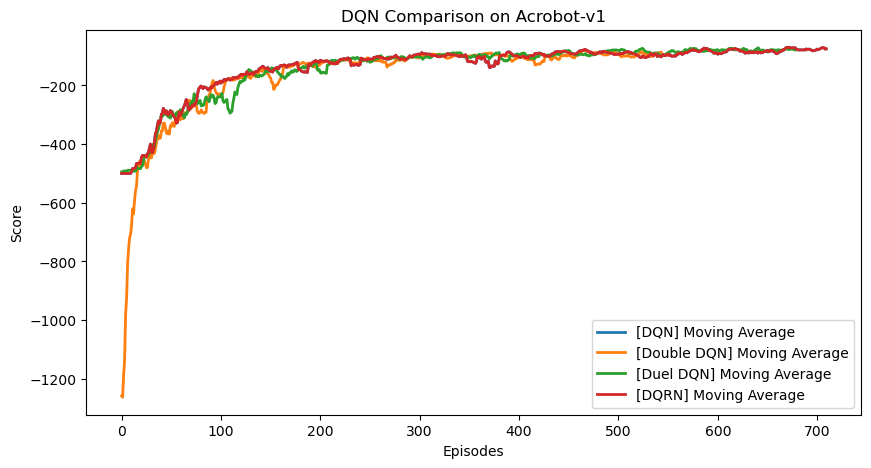

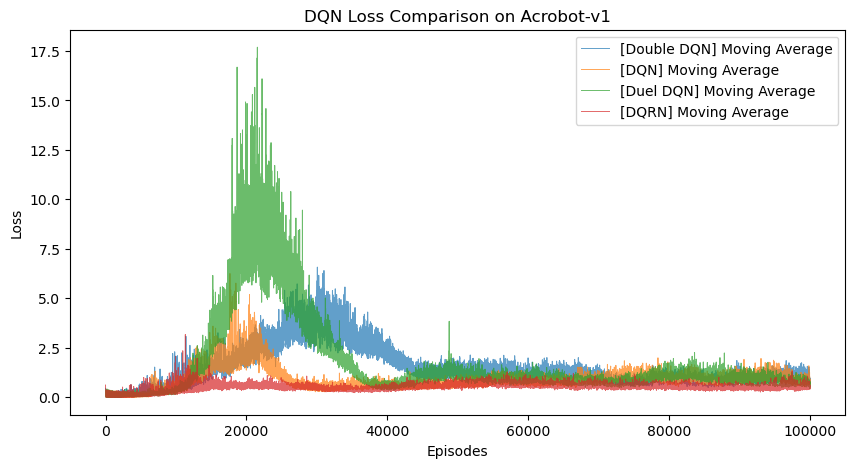

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# 이동 평균 함수 정의
def moving_average(data, window_size):
    """데이터의 이동 평균을 계산 (mode='valid')"""
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# 이동 평균 윈도우 크기 설정
window_size = 10

# 예제 데이터 (D_DQN, DoubleDQN, DuelDQN의 학습 점수 및 손실 값)
D_DQRN_scores = D_DQRN.scores
D_DQN_scores = D_DQN.scores
DoubleDQN_scores = DoubleDQN.scores
DuelDQN_scores = DuelDQN.scores

D_DQRN_losses = D_DQRN.losses
D_DQN_losses = D_DQN.losses
DoubleDQN_losses = DoubleDQN.losses
DuelDQN_losses = DuelDQN.losses

# ✅ 학습 결과 Score 그래프 출력
plt.figure(figsize=(10,5))
# plt.plot(D_DQN_scores, label="[DQN] Training Score", alpha=0.3)
# plt.plot(DoubleDQN_scores, label="[Double DQN] Training Score", alpha=0.3)
# plt.plot(DuelDQN_scores, label="[Duel DQN] Training Score", alpha=0.3)
plt.plot(moving_average(D_DQN_scores, window_size), label="[DQN] Moving Average", linewidth=2)
plt.plot(moving_average(DoubleDQN_scores, window_size), label="[Double DQN] Moving Average", linewidth=2)
plt.plot(moving_average(DuelDQN_scores, window_size), label="[Duel DQN] Moving Average", linewidth=2)
plt.plot(moving_average(D_DQN_scores, window_size), label="[DQRN] Moving Average", linewidth=2)
plt.xlabel("Episodes")
plt.ylabel("Score")
plt.legend()
plt.title("DQN Comparison on Acrobot-v1")
plt.show()

# ✅ 학습 결과 Loss 그래프 출력
plt.figure(figsize=(10,5))
# plt.plot(D_DQN_losses, label="[DQN] Training Loss", alpha=0.3)
# plt.plot(DoubleDQN_losses, label="[Double DQN] Training Loss", alpha=0.3)
# plt.plot(DuelDQN_losses, label="[Duel DQN] Training Loss", alpha=0.3)
plt.plot(moving_average(DoubleDQN_losses, window_size), label="[Double DQN] Moving Average", linewidth=0.7, alpha=0.7)
plt.plot(moving_average(D_DQN_losses, window_size), label="[DQN] Moving Average", linewidth=0.7, alpha=0.7)
plt.plot(moving_average(DuelDQN_losses, window_size), label="[Duel DQN] Moving Average", linewidth=0.7, alpha=0.7)
plt.plot(moving_average(D_DQRN_losses, window_size), label="[DQRN] Moving Average", linewidth=0.7, alpha=0.7)
plt.xlabel("Episodes")
plt.ylabel("Loss")
plt.legend()
plt.title("DQN Loss Comparison on Acrobot-v1")
plt.show()


### **[실험 브리핑]**

(1) 성능은 DQRN이 제일 높을 것으로 예상했고, 전통적인 DQN 제일 불안정하고 낮게 나올 것이라 예상 <br>
(2) 하지만 의외로 Double DQN이 오리지널보다 초반에 불안정한 모습을 보였는데, 이는 target을 세울 때 행하는 자와 평가하는 자가 달라지면서 발생하는 문제로 보임 <br>
(3) DQN에서 Target-N을 다르게 하는 것은 max()를 향해 어쨌든 안정적으로 나아가게 함임. 하지만 Double을 할 경우, target이 진짜 최선의 행동이 아닐 수 있음 <br>
(4) 당장의 정보 내에서 최선이 아닌 행동으로 나아가는 경우가 반드시 생기게 되기 때문에 loss가 안정적으로 감소한 것이 아닌 것으로 보임 <br>
(5) 그에 반해 DQRN은 현재 정보 뿐만이 아니라, 과거 정보까지도 활용하기에 Loss가 매우 안정적으로 감소한 것을 확인할 수 있음 <br>
(6) 그렇다면 더 어려운 환경에선 어떻게 성능 차이가 날까? (심화 스터디)

## **심화 실험 - LunarLander**

In [23]:
config = {
    "env_name": "LunarLander-v3",  # Acrobot-v1 대신 LunarLander-v3 사용
    "batch": 64,
    "buffer_size": 10000,
    "lr": 0.001,
    "gamma": 0.99,
    "epsilon_init": 1.0,
    "epsilon_min": 0.01,
    "epsilon_decay": 0.995,
    "n_step": 100000,
    "n_train_start": 1000,
    "target_update_freq": 200,
    "test_freq": 1000,
}

# ✅ CUDA 설정
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

# ✅ 환경 초기화
env = gym.make(config["env_name"], render_mode="rgb_array")
test_env = gym.make(config["env_name"], render_mode="rgb_array")
dState = env.observation_space.shape[0]
dAction = env.action_space.n

Using device: cuda


In [24]:
D_DQRN = DQRN(env, test_env, RNNQnet, config, DEVICE)
D_DQRN.experience_before_train()  # 학습 전 리플레이 버퍼 채우기
D_DQRN_test_score = D_DQRN.train()

D_DQN = DQN(env, test_env, QNetwork, config, DEVICE)
D_DQN.experience_before_train()  # 학습 전 리플레이 버퍼 채우기
D_DQN_test_score = D_DQN.train()

DoubleDQN = Double_DQN(env, test_env, QNetwork, config, DEVICE)
DoubleDQN.experience_before_train()  # 학습 전 리플레이 버퍼 채우기
DoubleDQN_test_score = DoubleDQN.train()

DuelDQN = DQN(env, test_env, Duel_Qnet, config, DEVICE)
DuelDQN.experience_before_train()  # 학습 전 리플레이 버퍼 채우기
DuelDQN_test_score = DuelDQN.train()

100%|███████████████████████████████████████████████████████| 100000/100000 [06:19<00:00, 263.51it/s]


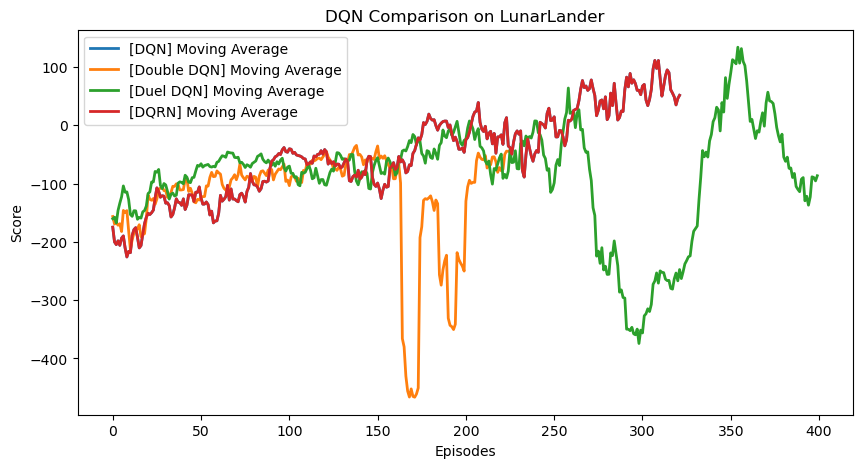

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 이동 평균 함수 정의
def moving_average(data, window_size):
    """데이터의 이동 평균을 계산 (mode='valid')"""
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# 이동 평균 윈도우 크기 설정
window_size = 10

# 예제 데이터 (D_DQN, DoubleDQN, DuelDQN의 학습 점수 및 손실 값)
D_DQRN_scores = D_DQRN.scores
D_DQN_scores = D_DQN.scores
DoubleDQN_scores = DoubleDQN.scores
DuelDQN_scores = DuelDQN.scores

D_DQRN_losses = D_DQRN.losses
D_DQN_losses = D_DQN.losses
DoubleDQN_losses = DoubleDQN.losses
DuelDQN_losses = DuelDQN.losses

# ✅ 학습 결과 Score 그래프 출력
plt.figure(figsize=(10,5))
# plt.plot(D_DQN_scores, label="[DQN] Training Score", alpha=0.3)
# plt.plot(DoubleDQN_scores, label="[Double DQN] Training Score", alpha=0.3)
# plt.plot(DuelDQN_scores, label="[Duel DQN] Training Score", alpha=0.3)
plt.plot(moving_average(D_DQN_scores, window_size), label="[DQN] Moving Average", linewidth=2)
plt.plot(moving_average(DoubleDQN_scores, window_size), label="[Double DQN] Moving Average", linewidth=2)
plt.plot(moving_average(DuelDQN_scores, window_size), label="[Duel DQN] Moving Average", linewidth=2)
plt.plot(moving_average(D_DQN_scores, window_size), label="[DQRN] Moving Average", linewidth=2)
plt.xlabel("Episodes")
plt.ylabel("Score")
plt.legend()
plt.title("DQN Comparison on LunarLander")
plt.show()

# ✅ 학습 결과 Loss 그래프 출력
plt.figure(figsize=(10,5))
# plt.plot(D_DQN_losses, label="[DQN] Training Loss", alpha=0.3)
# plt.plot(DoubleDQN_losses, label="[Double DQN] Training Loss", alpha=0.3)
# plt.plot(DuelDQN_losses, label="[Duel DQN] Training Loss", alpha=0.3)
plt.plot(moving_average(DoubleDQN_losses, window_size), label="[Double DQN] Moving Average", linewidth=0.7, alpha=0.7)
plt.plot(moving_average(D_DQN_losses, window_size), label="[DQN] Moving Average", linewidth=0.7, alpha=0.7)
plt.plot(moving_average(DuelDQN_losses, window_size), label="[Duel DQN] Moving Average", linewidth=0.7, alpha=0.7)
plt.plot(moving_average(D_DQRN_losses, window_size), label="[DQRN] Moving Average", linewidth=0.7, alpha=0.7)
plt.xlabel("Episodes")
plt.ylabel("Loss")
plt.legend()
plt.title("DQN Loss Comparison on LunarLander")
plt.show()


In [ ]:
render_simulation(env, D_DQRN, num_episodes=1, save_path="DQN_Lunar.gif", rnn_true=True)
render_simulation(env, D_DQN, num_episodes=1, save_path="DoubleDQN_Lunar.gif")
render_simulation(env, DoubleDQN, num_episodes=1, save_path="DuelingDQN_Lunar.gif")
render_simulation(env, DuelDQN, num_episodes=1, save_path="DQRN_Lunar.gif")